In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
from IPython.display import Image, display
from io import BytesIO
from PIL import Image


In [32]:
data_path = r"DATA_PHOTOS_IAA_NUMBERS"
# Load images using OpenCV
image_list = []
file_names = []
for filename in os.listdir(data_path):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.tif'):
        img = cv2.imread(os.path.join(data_path, filename))
        image_list.append(img)
        file_names.append (filename)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 108456960 bytes in function 'cv::OutOfMemoryError'


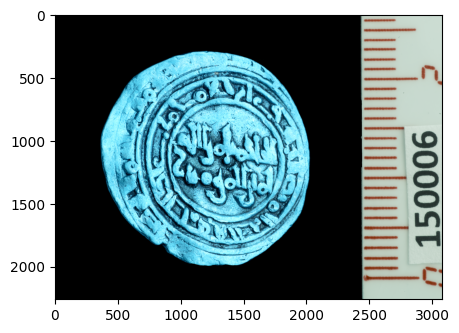

In [33]:
fig = plt.figure(figsize=(5, 6))
  
fig.add_subplot(1, 1, 1)
plt.imshow(image_list[0])

In [4]:
# base_url = 'https://github.com/Aviost111/final_proj/tree/main/REAL_DATA/'
# start_number = 150006  # Starting number
# end_number = 151051  # Ending number
# num_images_per_group = 2  # Number of images per group (e.g., 150006.1.tif and 150006.2.tif)

# image_urls = []

# for i in range(start_number, end_number + 1):
#     for j in range(1, num_images_per_group + 1):
#         image_urls.append(f'{base_url}{i}.{j}.tif')


In [5]:
# len(image_urls)

## First task

Isolate the coin from the image (remove the ruler and the note).

In [34]:
def crop_coin_simple(img, output_path):

    # Convert the image to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds of the color range for the coin
    lower_bound = np.array([20, 50, 50])  # Adjust these values based on the coin's color
    upper_bound = np.array([30, 255, 255])

    # Create a mask using the color range
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Choose the largest contour (assumed to be the coin)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Find extreme points (leftmost, rightmost, topmost, bottommost) of the contour
    leftmost = tuple(largest_contour[largest_contour[:,:,0].argmin()][0])
    rightmost = tuple(largest_contour[largest_contour[:,:,0].argmax()][0])
    topmost = tuple(largest_contour[largest_contour[:,:,1].argmin()][0])
    bottommost = tuple(largest_contour[largest_contour[:,:,1].argmax()][0])

    # Define the region of interest (ROI) using the coordinates of the bounding box
    roi = img[topmost[1]:bottommost[1], leftmost[0]:rightmost[0]]

    # Save the cropped region
    cv2.imwrite(output_path, roi)
            

In [39]:
def crop_images(output_dir , image_list, file_names):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Process each image in image_list
    for idx, img in enumerate(image_list): 
        output_path = os.path.join(output_dir, file_names[idx])
        crop_coin_simple(img, output_path)
        #print(f"Image {idx} cropped and saved to {output_path}")


In [42]:
crop_images("REAL_DATA_CROPPED1",image_list, file_names)

In [4]:
def add_padding(image, target_size):
    # Calculate padding dimensions
    h, w = image.shape[:2]
    target_h, target_w = target_size
    pad_h = max(0, target_h - h)
    pad_w = max(0, target_w - w)
    
    # Add padding to the image
    padded_image = cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    
    return padded_image 
    
# Load images using OpenCV
data_path = "REAL_DATA_CROPPED1"
image_list = []
file_names = []
max_height = 0
max_width = 0

# Determine maximum width and height
for filename in os.listdir(data_path):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.tif'):
        img = cv2.imread(os.path.join(data_path, filename))
        h, w = img.shape[:2]
        max_height = max(max_height, h)
        max_width = max(max_width, w)
        image_list.append(img)
        file_names.append(filename)
       
# Add padding to each image
padded_image_list = []
for img in image_list:
    padded_img = add_padding(img, (max_height, max_width))
    padded_image_list.append(padded_img)

# Save padded images to a new directory
output_dir = "REAL_DATA_Padded"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, padded_img in enumerate(padded_image_list):
    output_path = os.path.join(output_dir, file_names[i])
    cv2.imwrite(output_path, padded_img)


In [5]:
# Check if all images have the same size
sizes = set()
for img in padded_image_list:
    sizes.add(img.shape[:2])

if len(sizes) == 1:
    print("All images have the same size.")
    print("Size:", sizes.pop())
else:
    print("Images have different sizes.")


All images have the same size.
Size: (2245, 2172)


## combining two sides of each coin

In [19]:
# Function to combine two images
def combine_images(image1_path, image2_path, output_folder):
    # Load images
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)

    # Resize images to have the same dimensions (optional, depends on your use case)
    image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))

    # Combine images horizontally
    combined_image = cv2.hconcat([image1, image2])

    # Extract file names
    image1_name = os.path.basename(image1_path)
    image2_name = os.path.basename(image2_path)

    # Generate output file name
    output_filename = f"combined_{image1_name}_{image2_name}"
    
    # Save the combined image
    output_path = os.path.join(output_folder, output_filename)
    cv2.imwrite(output_path, combined_image)

# Path to your folder containing images
input_folder_path = r"REAL_DATA_Padded"

# Path to the folder where combined images will be saved
output_folder_path = r"Combined_images"

# Get a list of image files in the input folder
image_files = os.listdir(input_folder_path)

# Iterate through the image files to find pairs with names like "some.1" and "some.2"
for image_file in image_files:
    if image_file.endswith('.1.jpg') or image_file.endswith('.1.png') or image_file.endswith('.1.tif') :
        image1_path = os.path.join(input_folder_path, image_file)
        image2_name = image_file.replace(".1", ".2")
        image2_path = os.path.join(input_folder_path, image2_name)
        if os.path.exists(image2_path):
            combine_images(image1_path, image2_path, output_folder_path)


combined_150006.1.tif_150006.2.tif
combined_150007.1.tif_150007.2.tif
combined_150008.1.tif_150008.2.tif
combined_150009.1.tif_150009.2.tif
combined_150014.1.tif_150014.2.tif
combined_150015.1.tif_150015.2.tif
combined_150016.1.tif_150016.2.tif
combined_150017.1.tif_150017.2.tif
combined_150030.1.jpg_150030.2.jpg
combined_150031.1.jpg_150031.2.jpg
combined_150032.1.jpg_150032.2.jpg
combined_150033.1.jpg_150033.2.jpg
combined_150034.1.jpg_150034.2.jpg
combined_150037.1.jpg_150037.2.jpg
combined_150039.1.jpg_150039.2.jpg
combined_150040.1.jpg_150040.2.jpg
combined_150041.1.jpg_150041.2.jpg
combined_150042.1.jpg_150042.2.jpg
combined_150043.1.jpg_150043.2.jpg
combined_150044.1.jpg_150044.2.jpg
combined_150045.1.jpg_150045.2.jpg
combined_150046.1.jpg_150046.2.jpg
combined_150048.1.jpg_150048.2.jpg
combined_150049.1.jpg_150049.2.jpg
combined_150050.1.jpg_150050.2.jpg
combined_150051.1.jpg_150051.2.jpg
combined_150052.1.jpg_150052.2.jpg
combined_150053.1.jpg_150053.2.jpg
combined_150054.1.jp

In [12]:
image_files

['150006.1.tif',
 '150006.2.tif',
 '150007.1.tif',
 '150007.2.tif',
 '150008.1.tif',
 '150008.2.tif',
 '150009.1.tif',
 '150009.2.tif',
 '150014.1.tif',
 '150014.2.tif',
 '150015.1.tif',
 '150015.2.tif',
 '150016.1.tif',
 '150016.2.tif',
 '150017.1.tif',
 '150017.2.tif',
 '150030.1.jpg',
 '150030.2.jpg',
 '150031.1.jpg',
 '150031.2.jpg',
 '150032.1.jpg',
 '150032.2.jpg',
 '150033.1.jpg',
 '150033.2.jpg',
 '150034.1.jpg',
 '150034.2.jpg',
 '150036.1.jpg',
 '150037.1.jpg',
 '150037.2.jpg',
 '150038.1.jpg',
 '150039.1.jpg',
 '150039.2.jpg',
 '150040.1.jpg',
 '150040.2.jpg',
 '150041.1.jpg',
 '150041.2.jpg',
 '150042.1.jpg',
 '150042.2.jpg',
 '150043.1.jpg',
 '150043.2.jpg',
 '150044.1.jpg',
 '150044.2.jpg',
 '150045.1.jpg',
 '150045.2.jpg',
 '150046.1.jpg',
 '150046.2.jpg',
 '150047.1.jpg',
 '150048.1.jpg',
 '150048.2.jpg',
 '150049.1.jpg',
 '150049.2.jpg',
 '150050.1.jpg',
 '150050.2.jpg',
 '150051.1.jpg',
 '150051.2.jpg',
 '150052.1.jpg',
 '150052.2.jpg',
 '150053.1.jpg',
 '150053.2.jpg